In [2]:
import re
import csv
from datetime import datetime
import pandas as pd

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from myutils.logparseutil import read_log_file, split_into_blocks, extract_block_data, analyze_log
from myutils.plotsutil import plot_ycol_vs_xcol, plot_phase_cumulative

#### 📄 Vehicle Block Extraction from Simulation Log

This snippet processes the simulation log file to extract structured vehicle block data into a Pandas DataFrame for analysis.



In [3]:
# simulation log file
log_file = '../data/log_2025-11-07__16;50;25.txt'

In [4]:
# read log file
log_lines = read_log_file(log_file)
# split into carrier blocks
blocks = split_into_blocks(log_lines)

extracted_data = []

# Extract structured data
data = [
    extract_block_data(block, i + 1)
    for i, block in enumerate(blocks)
    if extract_block_data(block, i + 1) is not None
]

# Convert to DataFrame
extracted_df = pd.DataFrame(data)

#### 📊 `extracted_df` Overview

`extracted_df` is a Pandas DataFrame containing structured data extracted from vehicle block operations in a MATSim simulation log. Each row represents a single vehicle's block execution.

##### 🔢 Columns Explained

| Column           | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `vehicle`        | Unique identifier assigned to each vehicle block (sequential integer).      |
| `number_of_jobs` | Number of jobs assigned to the vehicle during its block operation.          |
| `block_time_ms`  | Total duration of the block operation in milliseconds (end - start time).   |
| `algo_time_ms`   | Time taken by the vrp algorithm to compute the vrp solution, in milliseconds.       |
| `start_ms`       | Start timestamp of the block operation, converted to milliseconds.          |
| `end_ms`         | End timestamp of the block operation, converted to milliseconds.            |

This DataFrame is used for performance analysis, correlation studies, and depot-level aggregation.


In [5]:
# view extracted data

extracted_df

,vehicle,number_of_jobs,block_time_ms,algo_time_ms,start_ms,end_ms
0,1,10,864,292,60872360,60873224
1,2,12,175,110,60873224,60873399
2,3,12,89,67,60873399,60873488
3,4,10,96,54,60873505,60873601
4,5,12,91,71,60873601,60873692
...,...,...,...,...,...,...
2962,2963,12,252,75,64248829,64249081
2963,2964,6,27,17,64249098,64249125
2964,2965,7,30,26,64249146,64249176
2965,2966,81,1185,556,64249196,64250381


### 🚦 <font color="orange">Vehicle Block duration summary</font>

(<Figure size 1400x500 with 2 Axes>,
 (<Axes: title={'center': 'All data (n=2967)'}, xlabel='Number Of Jobs', ylabel='Block Time Ms'>,
  <Axes: title={'center': 'Block Time Ms < 5000 (threshold) (n=2835)'}, xlabel='Number Of Jobs', ylabel='Block Time Ms'>))

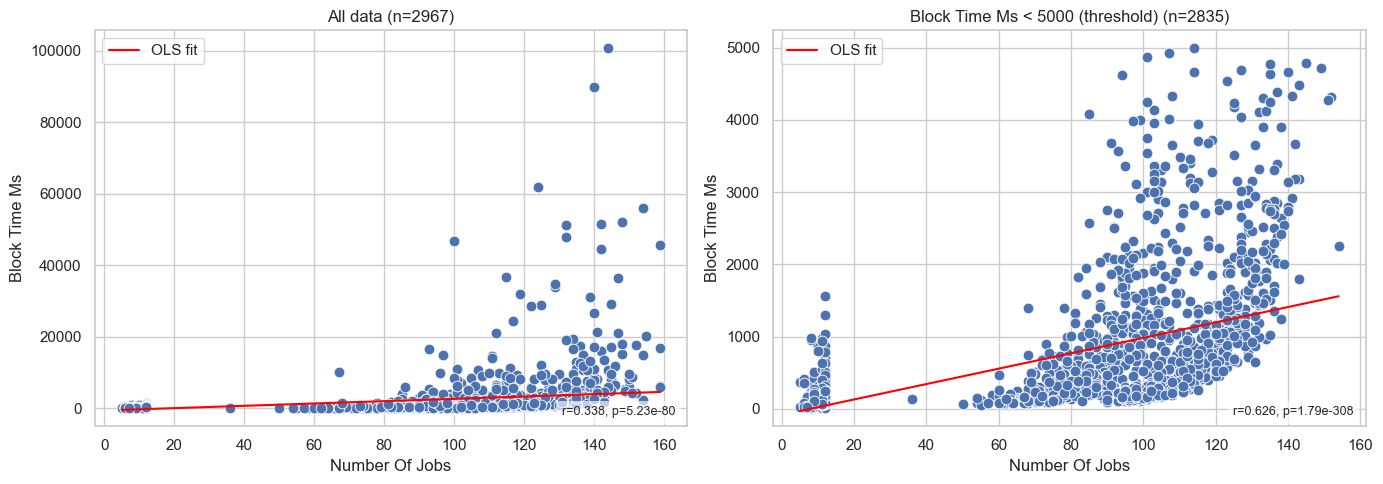

In [6]:
# plot block_time_ms

plot_ycol_vs_xcol(extracted_df, 'block_time_ms', threshold_ms=5000)

This snippet computes how many vehicle block operations exceeded 5000 ms and prints that count and its share of all vehicle blocks.


In [8]:
total_no_of_vehicles = extracted_df.shape[0]
veh_blocks_above_5000 = extracted_df[extracted_df['block_time_ms']>5000].shape[0]

print(f"Number of block operations above 5000ms = {veh_blocks_above_5000}")

print(f"That's {veh_blocks_above_5000/total_no_of_vehicles*100:.2f} % of the total {total_no_of_vehicles} vehicle block operations")

Number of block operations above 5000ms = 132
That's 4.45 % of the total 2967 vehicle block operations


### 🚦 <font color="orange">VRP Algorithm duration summary</font>

(<Figure size 1400x500 with 2 Axes>,
 (<Axes: title={'center': 'All data (n=2967)'}, xlabel='Number Of Jobs', ylabel='Algo Time Ms'>,
  <Axes: title={'center': 'Algo Time Ms < 5000 (threshold) (n=2907)'}, xlabel='Number Of Jobs', ylabel='Algo Time Ms'>))

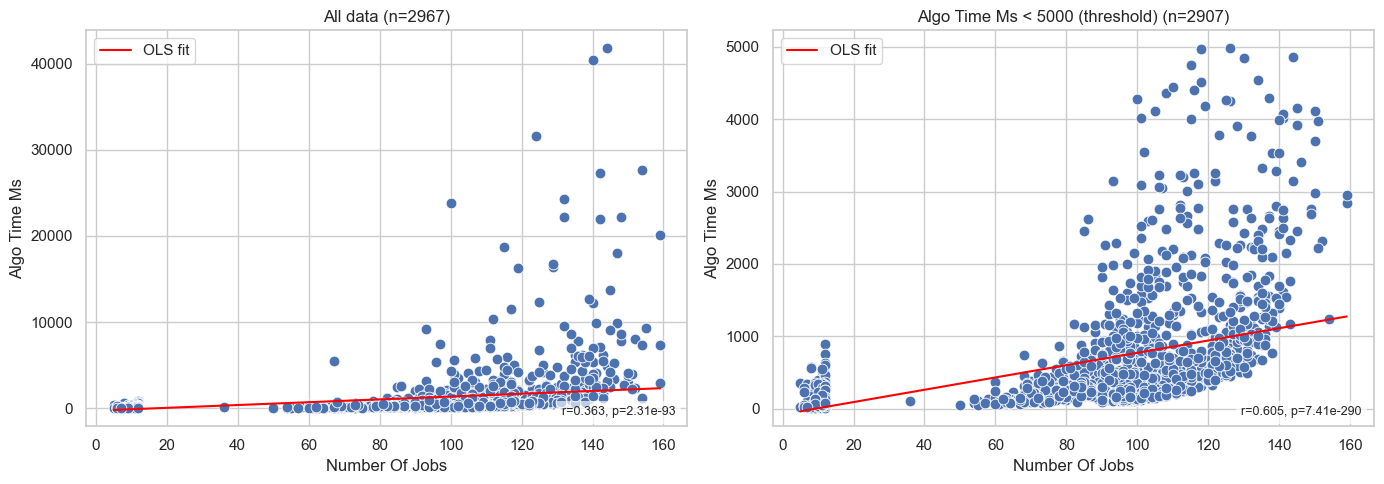

In [9]:
# plot block_time_ms

plot_ycol_vs_xcol(extracted_df, 'algo_time_ms', threshold_ms=5000)

This snippet computes how many vrp algorithm run operations exceeded 5000 ms and prints that count and its share of all vehicle blocks.

In [10]:
total_no_of_vehicles = extracted_df.shape[0]
algo_run_above_5000 = extracted_df[extracted_df['algo_time_ms']>5000].shape[0]

print(f"Number of algorithm run operations above 5000ms = {algo_run_above_5000}")

print(f"That's {algo_run_above_5000/total_no_of_vehicles*100:.2f} % of the total {total_no_of_vehicles} algorithm run operations")

Number of algorithm run operations above 5000ms = 60
That's 2.02 % of the total 2967 algorithm run operations


#### 🧪 Analyzing the Log File

This snippet runs the full log analysis pipeline using the `analyze_log()` function. It extracts structured insights from the simulation log and prints two key summary tables.

In [11]:
cep_summary, phase_timing = analyze_log(log_file)
print("📦 CEPDepot Summary")
cep_summary.head()

📦 CEPDepot Summary


,CEPDepot,total_jobs,operation_time_ms
0,CEPDepot0,1805,46103
1,CEPDepot1,6665,53036
2,CEPDepot2,2267,32973
3,CEPDepot3,1933,8679
4,CEPDepot4,10556,533236


(<Figure size 1400x500 with 1 Axes>,
 <Axes: title={'center': 'Total Jobs vs Operation Time Ms (all data)'}, xlabel='Total Jobs', ylabel='Operation Time Ms'>)

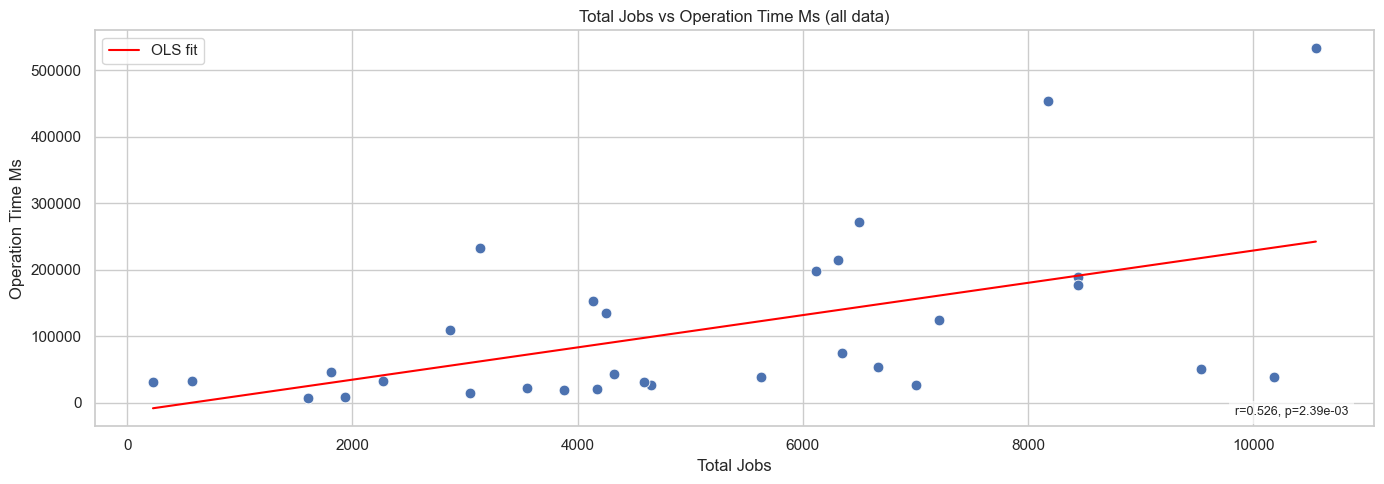

In [12]:
# plotting time per cepdepot operation against number of jobs

plot_ycol_vs_xcol(cep_summary, 'operation_time_ms', x_column='total_jobs')

In [13]:
print("\n⏱️ Simulation Phase Timing")
phase_timing


⏱️ Simulation Phase Timing


,Phase,Duration_ms,hh_mm_ss,share_of_total_time
0,Preprocessing,246670,00:04:06,6.75
1,CEPDepot Ops,3380501,00:56:20,92.53
2,Iteration,22377,00:00:22,0.61
3,Post-process,4057,00:00:04,0.11
4,Total,3653605,01:00:53,100.00


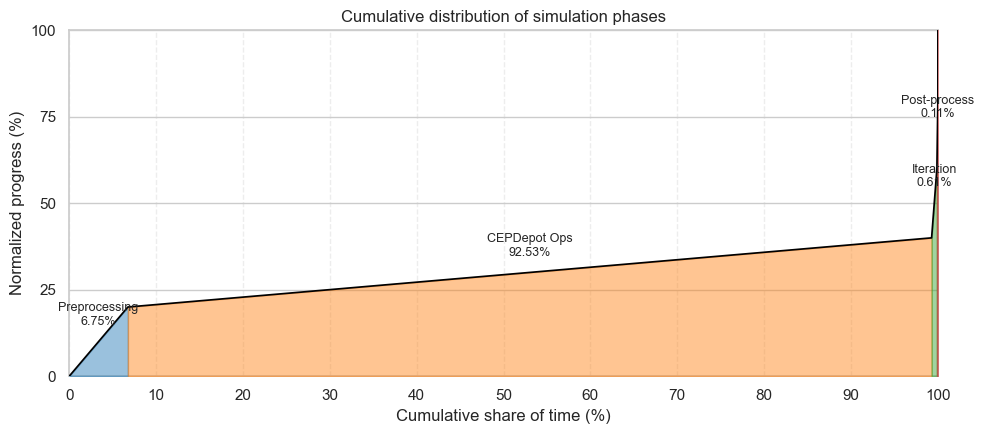

In [14]:
# plot cummulative distribution of 

fig, ax = plot_phase_cumulative(phase_timing)

